In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn
from sklearn import linear_model
import seaborn as sns
import statsmodels.formula.api as smf
import math
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline 
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [3]:
df = pd.read_csv('Offenses known 2013.csv', skiprows=4)
df.head(20)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.000,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,"2,577",3,0.000,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,"2,846",3,0.000,nan,0,0,3,16,1,15,0,0.000
3,Albany,"97,956",791,8.000,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0.000,nan,3,4,16,223,53,165,5,nan
5,Alfred Village,"4,089",5,0.000,nan,0,3,2,46,10,36,0,nan
6,Allegany Village,"1,781",3,0.000,nan,0,0,3,10,0,10,0,0.000
7,Amherst Town,"118,296",107,1.000,nan,7,31,68,"2,118",204,"1,882",32,3.000
8,Amityville Village,"9,519",9,0.000,nan,2,4,3,210,16,188,6,1.000
9,Amsterdam,"18,182",30,0.000,nan,0,12,18,405,99,291,15,0.000


In [4]:
# Check what type of data I have.
df.dtypes

City                                       object
Population                                 object
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter    float64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2                object
Robbery                                    object
Aggravated\nassault                        object
Property\ncrime                            object
Burglary                                   object
Larceny-\ntheft                            object
Motor\nvehicle\ntheft                      object
Arson3                                    float64
dtype: object

In [5]:
# Rename murder to a more convenient name.
df['Murder'] = df['Murder and\nnonnegligent\nmanslaughter']
df['Property_Crime'] = df['Property\ncrime']

# first remove the commas 
df['Robbery'] = df['Robbery'].str.replace(',', '')
df['Population'] = df['Population'].str.replace(',', '')
df['Property_Crime'] = df['Property_Crime'].str.replace(',', '')

In [6]:
# change robbery, and population to int.
df[['Robbery', 'Population', 'Murder']] = df[['Robbery', 'Population', 'Murder']].apply(pd.to_numeric)

In [7]:
# Make violent crime a usable stat. Get rid of the commas.
df['Violent_Crime'] = df['Violent\ncrime'].str.replace(',', '')
# Turn Violent Crime into an int.
df['Violent_Crime'] = df['Violent_Crime'].apply(pd.to_numeric)
# Turn Property Crime into an int. Already transformed it up top in an earlier cell.
df['Property_Crime'] = df['Property_Crime'].apply(pd.to_numeric)

In [8]:
# Make sure that all the data that I've selected is usable. 
data = df[['Murder', 'Robbery', 'Population', 'Violent_Crime', 'Property_Crime']].dropna()

In [9]:
# Attempting to clean the data a bit before using it.
data.describe()

,Murder,Robbery,Population,Violent_Crime,Property_Crime
count,348.000,348.000,348.000,348.000,348.000
mean,1.566,72.902,40037.632,201.595,792.606
std,18.304,1031.033,450037.368,2815.269,7659.725
min,0.000,0.000,526.000,0.000,0.000
25%,0.000,0.000,3003.000,2.000,40.500
50%,0.000,1.000,7233.500,6.000,112.500
75%,0.000,5.000,18427.500,22.000,341.000
max,335.000,19170.000,8396126.000,52384.000,141971.000


In [10]:
# Remove the outlier in robbery.
data = data.drop([216])

(array([285.,  44.,   6.,   7.,   1.,   1.,   0.,   1.,   1.,   1.]),
 array([   526. ,  26352.3,  52178.6,  78004.9, 103831.2, 129657.5,
        155483.8, 181310.1, 207136.4, 232962.7, 258789. ]),
 <a list of 10 Patch objects>)

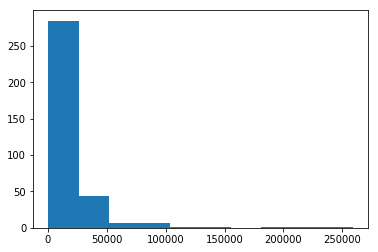

In [11]:
# Control for population 
plt.hist(data['Population']) 

In [12]:
# Most population counts don't exceed 50k, but I will
# use up to 65k to account for some of the outliers and model the population.
data = data.query('Population<65000')

In [13]:
data.describe()

,Murder,Robbery,Population,Violent_Crime,Property_Crime
count,333.000,333.000,333.000,333.000,333.000
mean,0.219,6.712,11634.640,22.399,244.967
std,0.917,21.581,12375.324,60.894,368.681
min,0.000,0.000,526.000,0.000,0.000
25%,0.000,0.000,2846.000,2.000,38.000
50%,0.000,1.000,6794.000,6.000,107.000
75%,0.000,4.000,15374.000,18.000,313.000
max,10.000,204.000,61686.000,584.000,2807.000


# OLS Model 

In [14]:
# Model with just X and Y were grossly overfitted. Must fix
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Property_Crime'].values.reshape(-1, 1)
X = data[['Population','Robbery','Violent_Crime', 'Murder']]
# Square the parameters so that we can achieve homoscedasticity.
data['Robbery Sqrd'] = data['Robbery'] * data['Robbery']
data['Violent Crime Sqrd'] = data['Violent_Crime'] * data['Violent_Crime']
data['Murder Sqrd'] = data['Murder'] * data['Murder']
data['Population Sqrd'] = data['Population'] * data['Population']
data['Property Crime Sqrd'] = data['Property_Crime'] * data['Property_Crime']
 

X2 = data[['Robbery Sqrd', 'Violent Crime Sqrd', 'Murder Sqrd', 'Population Sqrd']]
Y2 = data['Property Crime Sqrd'].values.reshape(-1, 1)

regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 1.62739387e-02 -7.50619365e+00  6.02236144e+00 -5.82503701e+01]]

Intercept: 
 [-16.12271574]

R-squared:
0.8263741107495083


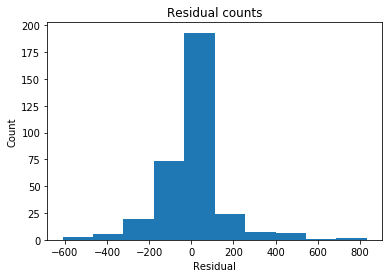

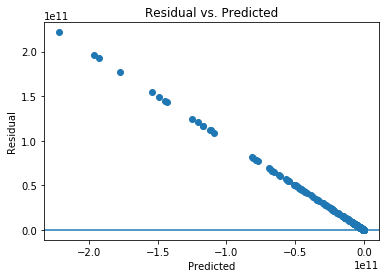

In [15]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Property_Crime']

# Calculate the error, aka residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Use the square values of the features to achieve homoskedasticity
predicted2 = regr.predict(X2).ravel()
residual2 = actual - predicted2

plt.scatter(predicted2, residual2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


- Lowering the population count from 75k to 65k made only a slight difference in my actual vs predicted plot.
- Removing outliers allowed my model to resemble more closely to the multivariate normality assumption.
- My regression model is more homoskedastic now, but it's in a descending manner instead of ascending manner.
- I chose to use population, robbery, murder, and violent crimes because I thought those would be the things that had - the biggest correlation with property crime.
- After removing outliers, my model isn't as overfitted and can supposedly evaluate 82% of the variance within the model.

# Cross Fold Validation 

In [16]:
# Attempting to see if any variables are overfitting.
model = regr.fit(X, Y)

from sklearn.model_selection import cross_val_score
cross_val_score(model, X, Y, cv=5)

array([0.81216744, 0.54001992, 0.78535785, 0.69236108, 0.88903254])

# KNN Regression

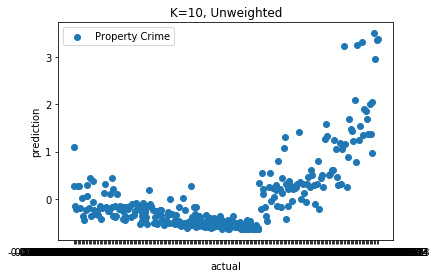

In [17]:
# Use KNN to compare to model 1 OLS
# data = df[['Murder', 'Robbery', 'Population', 'Violent_Crime', 'Property_Crime']]

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn import neighbors
from scipy import stats

knn = neighbors.KNeighborsRegressor(n_neighbors=10)

# Our input data frame will be the z-scores this time instead of raw data.
X = pd.DataFrame({
    'Murder': stats.zscore(data.Murder),
    'Robbery': stats.zscore(data.Robbery), 
    'Population': stats.zscore(data.Population),
    'Violent_Crime': stats.zscore(data.Violent_Crime)
})

# Fit our model.
Y = pd.DataFrame({'Property_Crime': stats.zscore(data.Property_Crime)})
knn.fit(X, Y)

# Make point predictions on the data set using the fit model.
k_predict = knn.predict(X)
k_actual = Y


plt.scatter(k_actual, k_predict, label = 'Property Crime')
plt.legend()
plt.xlabel('actual')
plt.ylabel('prediction')
plt.title('K=10, Unweighted')
plt.show()


Unweighted looks really messy; lets see how weighted will look.

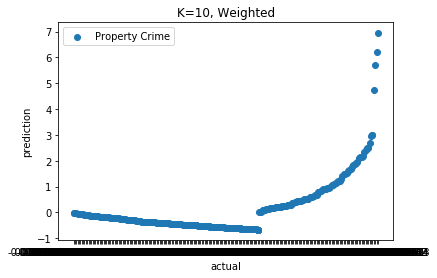

In [18]:
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights = 'distance')

knn_w.fit(X, Y)

# Make point predictions on the data set using the fit model.
kw_predict = knn_w.predict(X)
kw_actual = Y


plt.scatter(kw_actual, kw_predict, label = 'Property Crime')
plt.legend()
plt.xlabel('actual')
plt.ylabel('prediction')
plt.title('K=10, Weighted')
plt.show()

In [19]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=10)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.70 (+/- 0.14)
Weighted Accuracy: 0.74 (+/- 0.11)


# Comparing the OLS Model to the KNN Model

My OLS Regression model was 82.68% percent accurate while my KNN Model was only 74% accurate given the weighted model. Needless to say, my OLS regression model is the stronger prediction model. However, I don't believe that either model is inherently superior to the other. Either of the model's have the ability to do well; it's probably the type of data that determines which type of model is better suited for the job.

Currently, I like using the OLS Model more because I have more confidence and a better understanding of the OLS model at the moment. I would say that the OLS requires a bit more work than the KNN model since I have to make sure the variables are normal, homoscedastic and have low multicollinearity. Reaching those conditions take a bit of work but also lets me understand my data better. I also like that the OLS gives me coefficients so that I have a better implicit understanding of each feature's importance compared to the other features. I also like that my OLS model ran a bit faster than my KNN model.

The KNN model was a relatively quick cleaning process since it only requires that I normalize my data and pick k's. I chose to use the z scores this time instead of normalizing the data by rescaling it to 0 and 1. I had initially tried setting different k's to see if it would influence my model, but the improvements were slight ( I used 5, 8, and 15) so I ultimately stuck with using a k of 10.

Maybe the KNN model would have done better if I had picked another data set instead of a dataset that had purposefully been used to do OLS on before. Maybe this dataset in particular is better suited for OLS. KNN does better when than OLS when there are nonlinear relationships so if I had cleaned the data in a way that favored KNN(leave in more outliers maybe?), perhaps the KNN model would have done better.